# Setting up, prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib import colors
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import keras_tuner
import keras
import pandas as pd
from tensorflow.keras import layers
from keras import metrics
from sklearn import preprocessing
import math  
import datetime
import tensorflow_decision_forests as tfdf
import os
from keras.utils import plot_model
import tensorflow_datasets as tfds
from keras.utils import plot_model
import pydot
import serial
import time
import difflib
from sklearn.metrics.pairwise import cosine_similarity

# import graphviz
global plot_path
global w 
global h 
global dataDir
global dataFiles
global dataFiles_train 
global dataFiles_test 
global e

global data_train_nm
global dataset_train_ar
global dataset_test_ar
global dataset_val_ar

2023-12-03 18:19:54.638857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 18:19:54.638907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 18:19:54.638934: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 18:19:54.645990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CHECK TENSOR USING GPU
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2023-12-03 18:20:01.163202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 18:20:01.169623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 18:20:01.170006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See m

True

# Get data

## Get Data as if it's true data


In [3]:
# SEPERATE SUBJECTS TO DIFFERENT DATASET - NO SHUFFLE

dataDir = "/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
dataFiles_train = ['female_1.mat','male_1.mat','male_2.mat']
dataFiles_test = ['female_2.mat','female_3.mat']
# dataFiles=['female_1.mat']
e = 2.718281828459045


def normalize_arr(arr,i):
    signal = arr.copy()
    signal = signal.tolist()
    signal.append(int(i/2))
    signal = np.array(signal)
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    label = int(i/2)
    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))

    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data


def getData(dataFiles):
    data = [] #processed and normalised with pose_idx
    for file in dataFiles:
        data_path = dataDir+file
        print(data_path)
        mat = scipy.io.loadmat(data_path)
        mat.pop("__header__")
        mat.pop("__version__")
        mat.pop("__globals__")
        i=0

        plot_interval = 100
        plot_index = 0

        for channel in mat: 
        
            if(i%2==0):
                channel2 =  channel[:-1]
                channel2 += '2'
                sigs1 = mat[channel] 
                sigs2 = mat[channel2]
                sigs1_norm = []
                sigs2_norm = []

                for signal in sigs1:
                    # signal = normalize_arr(signal,i)
                    if(signal[0]<2):
                        sigs1_norm.append(signal)
                        sigs2_norm.append(signal)
                # for signal in sigs2:
                #     # signal = normalize_arr(signal,i)
                #     if(signal[0]<2):
                #         sigs2_norm.append(signal)

                if i==0:
                    data = get_channel_pair(sigs1_norm,sigs2_norm,i)
                else:
                    None
                    data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                    data += data_lc
            i+=1
    return data
def get_nm_data(dataFiles):
    data = getData(dataFiles)
    print(np.array(data).shape)
    print(data[-3])

    data_nm = np.copy(data)[:,:2]
    data_nm.shape
    nm_c1 =  preprocessing.normalize([data_nm.T[0]]).T.flatten()
    nm_c2 =  preprocessing.normalize([data_nm.T[1]]).T.flatten()
    df_data_nm = pd.DataFrame(np.vstack((nm_c1,nm_c2)).T, columns = ['channel1','channel2'])

    label_arr=[]

    for row in data:
        label_arr.append(int(row[2]))
    print(label_arr)

    data_nm = df_data_nm.assign(label=label_arr)
    return data_nm



#==========================================
def GetSpacedElements(array, numElems = 4):
    return array[np.round(np.linspace(0, len(array)-1, numElems)).astype(int)]

#////////////////////============
def display_signals(b):
    w = 20
    h = 20
    fig = plt.figure(figsize=(10, 10))
    columns = 1
    rows = 2

    for index in range(1,2+1):
        idx = 0
        fig.add_subplot(rows, columns, index)
        for signal in b:
            plt.plot(signal[index-1],label=str(idx))
            idx += 1
        plt.title('channel '+str(index))
        plt.legend(ncol=1)
        
            
    plt.show()
    fig = plt.figure(figsize=(20, 20))
    columns = 2
    rows = 3
    idx = 0

    for signal in b:
        fig.add_subplot(rows, columns, idx+1)
        plt.plot(signal[0],color='blue',label=str(0))
        plt.plot(signal[1],color='orange',label=str(1))
        idx += 1
        plt.title('pose '+str(idx-1))
        plt.legend(ncol=1)
            
    plt.show()


def reshape_data(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        tmp = reshape_data.tolist()
        tmp.append(int(label[i]))
        tmp = np.array(tmp)

        if(len(reshape_data)==n*2):
            newShape_data.append(tmp)
        i += n

    newShape_data = np.array(newShape_data)
    return newShape_data

def split_X(arr):
    arr = arr.T
    arr = arr[0:-1]
    arr = arr.T
    return arr
def split_y(arr):
    arr = arr.T
    arr = arr[-1]
    arr = arr.T.astype(np.uint8)
    return arr
def reshape_arr(arr):
    new_shape = []
    for row in arr:
        n_len =int(math.sqrt(len(row)))
        row = row.reshape(n_len,n_len)
        new_shape.append(row)
    return np.array(new_shape)
def reshape_arr_img_transfer(arr,n):
    new_shape = []
    for row in arr:
        n_len = len(row)
        # row =np.pad(row,(0,n-n_len),'symmetric')
        row =np.pad(row,(0,n-n_len),'constant',constant_values=10)
        row = row.reshape(n,n)
        new_shape.append(row)
    return np.array(new_shape)
def signal_to_3channelimg(arr):
    rgb_batch_ts =  np.repeat(arr[..., np.newaxis], 3, -1)
    rgb_batch_ts.shape
    return rgb_batch_ts
def reshape_for_conv2d(t,w,h):
    train_size = int(len(t) * len(t[0])* len(t[0][0]) / (w*h))
    reshaped_tuple = t.reshape(train_size, w,h, 1)
    return reshaped_tuple
def loadData(img_w_h_len):
    data_train_nm = get_nm_data(dataFiles_train)
    data_test_nm = get_nm_data(dataFiles_test)
    w = img_w_h_len
    h = img_w_h_len


    # dataset_train = data_train_nm
    dataset_test = data_test_nm

    val_test_mask = np.random.rand(len(data_train_nm)) < 0.5

    dataset_train = data_train_nm[val_test_mask]
    dataset_val = data_train_nm[~val_test_mask]

    n = int(img_w_h_len * img_w_h_len / 2)

    dataset_train_ar = reshape_data(n,dataset_train)
    dataset_test_ar = reshape_data(n,dataset_test)
    dataset_val_ar = reshape_data(n,dataset_val)
    return {'w':w,'h':h,'dataset_train_ar':dataset_train_ar,'dataset_test_ar':dataset_test_ar,'dataset_val_ar':dataset_val_ar,'data_train_nm':data_train_nm,'data_test_nm':data_test_nm}

def getX_y():
    X = split_X(dataset_train_ar)

    X_val = split_X(dataset_val_ar)
    y_val = split_y(dataset_val_ar)

    X_test = split_X(dataset_test_ar)
    y_test = split_y(dataset_test_ar)


    # OPTIONAL TURN X TO NxN
    X = reshape_arr(X)
    X_test = reshape_arr(X_test)
    X_val = reshape_arr(X_val)




    X = reshape_for_conv2d(X,w,h)
    X_test = reshape_for_conv2d(X_test,w,h)
    X_val = reshape_for_conv2d(X_val,w,h)
    return {'X':X,"X_val":X_val,'y_val':y_val,'X_test':X_test,'y_test':y_test}





In [4]:
def max_voting(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

# BLUETOOTH var define
global port
global bluetooth
def BlueToothConnect():
    port="/dev/rfcomm0"
    bluetooth = serial.Serial(port=port,   baudrate=9600)
    return {'port':port,'bluetooth':bluetooth}
# BLUETOOTH COM
def bluetoothCommand(pred):
    pose  = str(pred) + ";"
    # bluetooth.write(bytes(pose,   'utf-8'))
    time.sleep(1.2)
    print(pose)

In [5]:
loadedData = loadData(img_w_h_len=40)
w = loadedData['w']
h = loadedData['h']
dataset_train_ar = loadedData['dataset_train_ar']
dataset_test_ar = loadedData['dataset_test_ar']
dataset_val_ar = loadedData['dataset_val_ar']
data_train_nm = loadedData['data_train_nm']
data_test_nm = loadedData['data_test_nm']

/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/female_1.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/male_1.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/male_2.mat
(539820, 3)
[-0.029808, 0.199706, 5]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [6]:


X_Y = getX_y()
X = X_Y['X']
X_test = X_Y['X_test']
X_val = X_Y['X_val']
y_test = X_Y['y_test']
y_val = X_Y['y_val']

## predict by sample

In [7]:
load_model_1 = keras.models.load_model('./models/tuned_model_loss_0.7_0.7_acc_new_10_11.keras')
load_model_2 = keras.models.load_model('./models/tuned_model_loss_5.0_0.1_acc_us_15_11.keras')
# load_model_3 = model
load_model_3 = keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
load_model_4 = load_model_1
# load_model_4 = keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
# load_model_3 = keras.models.load_model('./models/model_0.4_40l_1c_new.keras')

2023-12-03 18:20:25.984505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 18:20:25.984887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 18:20:25.985160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
def getPredSample(test_sample):
    test_X_sample_rate = np.array_split(X_test,len(y_test)/(test_sample))
    test_y_sample_rate = np.array_split(y_test,len(y_test)/(test_sample))
    print(len(test_X_sample_rate))
    np.array(test_X_sample_rate[1]).shape
    tempt_y = []
    for ys in test_y_sample_rate:
        tempt_y.append(ys[0])
    test_y_sample_rate = tempt_y
    test_y_sample_rate = np.array(test_y_sample_rate)
    test_y_sample_rate
    return {'test_X_sample_rate':test_X_sample_rate,'test_y_sample_rate':test_y_sample_rate}

PredSample = getPredSample(test_sample=1)
test_X_sample_rate = PredSample['test_X_sample_rate']
test_y_sample_rate = PredSample['test_y_sample_rate']

671


In [9]:
def predFromMaxPred(X_test_rate,preds_label_c):
    ensemble_pred = []
    for i in np.arange(len(X_test_rate)):
        i=i
        arr = []
        for pred in preds_label_c:
            arr.append(pred[i])
        ensemble_pred.append(max_voting(arr))
    return max_voting(ensemble_pred)

In [10]:
def acquire_pred_for_each(pred_c):
    preds_label_c = []
    for preds in pred_c:
        pred_label = []
        for prediction in preds:
            pred_label.append(np.argmax(prediction))
        pred_label = np.array(pred_label)
        preds_label_c.append(pred_label)
    preds_label_c = np.array(preds_label_c)
    return preds_label_c
def drawPlotAlongSample(X_test_rate):
    XFlat = X_test_rate.flatten()
    sample = 50 # max 200 for clean code sake
    rate = sample *2
    XFlat = GetSpacedElements(XFlat,rate)
    XFlat1=XFlat[0:int(len(XFlat)/2)]
    XFlat2=XFlat[int(len(XFlat)/2):-1]

    plt.plot(XFlat1,color='blue',label=str(0))
    plt.plot(XFlat2,color='orange',label=str(1))
    plt.title("sEmg signal")
    plt.legend(ncol=1)  
    plt.savefig(plot_path)
    plt.pause(0.0001)
    plt.clf()

In [11]:
def predict_plot():
    global pred_rate
    for X_test_rate in test_X_sample_rate:
        drawPlotAlongSample(X_test_rate)

        preds_1 = load_model_1.predict(X_test_rate)
        preds_2 = load_model_2.predict(X_test_rate)
        preds_3 = load_model_3.predict(X_test_rate)

        pred_c = []
        pred_c.append(preds_1)
        pred_c.append(preds_2)
        pred_c.append(preds_3)
        pred_c = np.array(pred_c)


        preds_label_c = []
        for preds in pred_c:
            pred_label = []
            for prediction in preds:
                pred_label.append(np.argmax(prediction))
            pred_label = np.array(pred_label)
            preds_label_c.append(pred_label)
        

        preds_label_c = acquire_pred_for_each(pred_c)
        
        pred = predFromMaxPred(X_test_rate,preds_label_c)
        bluetoothCommand(pred)
        pred_rate.append(pred)
    pred_rate = np.array(pred_rate)

In [ ]:
global pred_rate
plot_path = "../app/assets/signal.png"
pred_rate = []
predict_plot()

In [14]:
len(test_X_sample_rate)

671



========================= test_y_sample_rate ==========================
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 

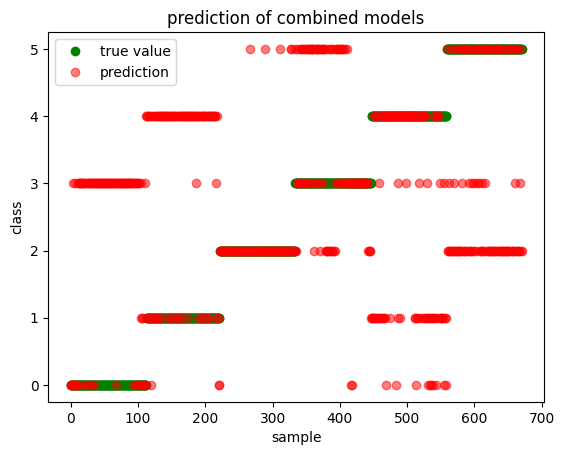

0.44709388971684055
0.7603806699773458


In [ ]:
print("\n\n========================= test_y_sample_rate ==========================\n",np.array(test_y_sample_rate[0:len(pred_rate)]))
print("\n\n====================== pred_rate =============================\n",np.array(pred_rate))


plt.plot(test_y_sample_rate[0:len(pred_rate)],'o',color ='green', label="true value")
plt.plot(pred_rate, 'o', color='red',alpha=0.5, label='prediction')

plt.xlabel("sample")
plt.ylabel("class")
plt.title("prediction of combined models")
plt.legend(ncol=1)

plt.show()

matrix1_flat = np.array(test_y_sample_rate[0:len(pred_rate)])
matrix2_flat = np.array(pred_rate)

similarity_ratio = cosine_similarity([matrix1_flat], [matrix2_flat])[0][0]
print(difflib.SequenceMatcher(None,matrix1_flat,matrix2_flat).ratio()*100)
print(similarity_ratio)